In [471]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

# MLE and MAP

1. Define a test problem in the following way:
    - ...
    - ...

In [472]:
def define_dataset(X, k, sigma):
    Phi = vander(X, k)
    
    #Define the true solution
    theta_true = np.ones((k, )) 
    
    Y = Phi @ theta_true
    gaussian_noise = np.random.normal(0, 1, Y.shape)
    Y = Y + sigma * gaussian_noise #Noisy Y

    D = (X, Y)

    return D

#Generalized Vandermonde Matrix
def vander(X, k):
    N = len(X)

    #Initialization
    phi = np.zeros((N, k))

    for j in range(k):
        phi[:,j] = X**j 

    return phi

In [473]:
#Degree of polynomial
#k = (int) (input("Choose a positive integer k: ")) 
'DA METTERE'

#Input dataset
#a = (int) (input("Choose an interval [a, b] --a: "))
#b = (int) (input("Choose an interval [a, b] --b: ")) 
'DA METTERE'
a = 0
b = 1

#sigma = (float) (input("Choose the variance of the noise: "))
'DA METTERE'

'DA METTERE'

In [474]:
N = 100 #number of datapoints
sigma = 0.1
k_chosen = 4

X = np.linspace(a, b, N)

X, Y = define_dataset(X, k_chosen, sigma)

2. Built a dataset D = {(X, Y)} sucht that..

In [475]:
D = (X, Y)

3. Pretend not to know the correct value of k...
    - Write a function that takes as input the training data D = (X,Y) ...
    - Write a function that takes as input a set of K-dimensional parameter vector ..
    - For different values of K, plot the training datapoints and the test datapoints with different colors,...

In [476]:
def f_MLE(X, Y):
    return lambda theta: 0.5 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y))**2

def grad_f_MLE(X, Y):
    return lambda theta: vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y)


def f_MAP(X, Y, lamda):
    return lambda theta: 0.5 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y))**2 + (lamda/2 * (np.linalg.norm(theta))**2)
    
def grad_f_MAP(X, Y, lamda):
    return lambda theta: vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y) + 2*lamda*np.array(theta)

In [477]:
def GD(f, grad_f, x0, kmax=100, tolf=1e-6, tolx=1e-6):
    # Initialization
    k = 0
    dim_m, dim_n = kmax+1, x0.shape[0]
    x = np.empty((dim_m, dim_n))
    f_val = np.empty((kmax+1, ))
    #grads = np.empty((dim_m, dim_n))
    
    # Assign the values for the first iteration
    x[k]=x0
    f_val[k] = f(x0)
    #grads[k] = grad_f(x0)
        
    # Handle the condition for the first iteration
    k+=1
    alpha = backtracking(f, grad_f, x[k])
    x[k]=x[k-1]-alpha*grad_f(x[k-1])
    f_val[k] = f(x[k])
    #grads[k] = grad_f(x[k])

    #Conditions
    cond1 = (np.linalg.norm(grad_f(x[k])) > tolf * grad_f(x[k-1])).all()
    cond2 = (np.linalg.norm(x[k] - x[k-1]) > tolx * np.linalg.norm(x[k-1])).all()
    conditions = cond1 and cond2

    # Start the iterations
    while (conditions and k < kmax):

        #Update k
        k = k+1
        
        # Update the value of x
        x[k] = x[k-1]-alpha*grad_f(x[k-1])
        
        #Update alpha
        alpha = backtracking(f, grad_f, x[k])
        
        #Update values 
        f_val[k] = f(x[k])
        #grads[k] = grad_f(x[k])

        #Update condintions
        cond1 = np.linalg.norm(grad_f(x[k])) > tolf * grad_f(x[k-1]).all()
        cond2 = np.linalg.norm(x[k] - x[k-1]) > tolx * np.linalg.norm(x[k-1]).all()
        conditions = cond1 and cond2
    
    #Truncate the vectors that are (eventually) too long
    x = x[:k+1]
    
    return x[-1]


def backtracking(f, grad_f, x):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x)) > f(x) - c * alpha * np.linalg.norm(grad_f(x)) ** 2:
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

In [478]:
def shuffle_data(X, Y):
    N = X.shape[0]
    indexes = np.arange(N)
    np.random.shuffle(indexes)

    X_shuffle = X[indexes]
    Y_shuffle = Y[indexes]

    return X_shuffle, Y_shuffle

def SGD(grad_l, w0, D, batch_size, n_epochs, lamda=0, alpha=0.01):
    X, Y = D  #Split D into X and Y
    N = X.shape[0]

    n_batch_per_epoch = N//batch_size
    tot_batch = n_batch_per_epoch * n_epochs
    
    w = np.array(w0)
    w_vector = np.zeros((tot_batch, len(w0)))
    
    #For each epoch    
    for epoch in range(n_epochs):
        X_shuffle, Y_shuffle = shuffle_data(X, Y)
        
        for b in range (n_batch_per_epoch):  
            #Sample M from D
            n = b*batch_size
            m = (b+1)*batch_size

            Mx = X_shuffle[n:m]
            My = Y_shuffle[n:m]

            if lamda==0:
                gradient=grad_l(Mx, My)
            else:
                gradient=grad_l(Mx, My, lamda)
            
            #Update w
            w=w-alpha*gradient(w)
            w_vector[epoch*n_batch_per_epoch + b, :] = w
    
    return w_vector[-1]


In [479]:
def MLE(D, k_trial, mod):
    X, Y = D
    
    Phi_trial = vander(X, k_trial)

    if mod[0]=='N':
        #Normal equation    
        A = Phi_trial.T @ Phi_trial
        b = Phi_trial.T @ Y

        try:
            L = scipy.linalg.cholesky(A, lower = True)
            y = scipy.linalg.solve_triangular(L, b, lower = True)
            theta_mle = scipy.linalg.solve_triangular(L.T, y)
        except:
            theta_mle = np.linalg.solve(Phi_trial.T @ Phi_trial, Phi_trial.T @ Y)

    elif mod[0]=='G':
        #Gradient Descent
        theta_mle = GD(f_MLE(X, Y), grad_f_MLE(X, Y), np.zeros((k_trial,)))

    else:
        #Stochastic Gradient Descent
        theta_mle = SGD(grad_f_MLE, np.zeros((k_trial, )), D, batch_size = 5, n_epochs = 10)

    return theta_mle

theta_mle_normal = MLE(D, k_chosen, 'Normal equation')
theta_mle_gd = MLE(D, k_chosen, 'GD')
theta_mle_sgd = MLE(D, k_chosen, 'SGD')

print("Theta, MLE - Normal equation: ", theta_mle_normal)
print("Theta, MLE - GD: ", theta_mle_gd)
print("Theta, MLE - SGD: ", theta_mle_sgd)

Theta, MLE - Normal equation:  [1.01571592 0.65316794 2.08313805 0.1757381 ]
Theta, MLE - GD:  [0.97559222 1.10480059 1.00508026 0.87071103]
Theta, MLE - SGD:  [1.05828925 1.06256874 0.92495086 0.80278296]


In [480]:
def split_data(X, Y, Ntrain):

    N = len(X)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

In [481]:
def polynomial_regression(X, k, theta):
    Phi = vander(X, k)
    return Phi @ theta

def error(D, k, theta):
    X, Y = D
    N = len(Y)

    f_theta = polynomial_regression(X, k, theta)

    return ((np.linalg.norm(f_theta - Y))**2) / N

For dierent values of K, plot the training datapoints and the test datapoints with dierent colors,
and visualize (as a continuous line) the learnt regression model fMLE (x). Comment the results.

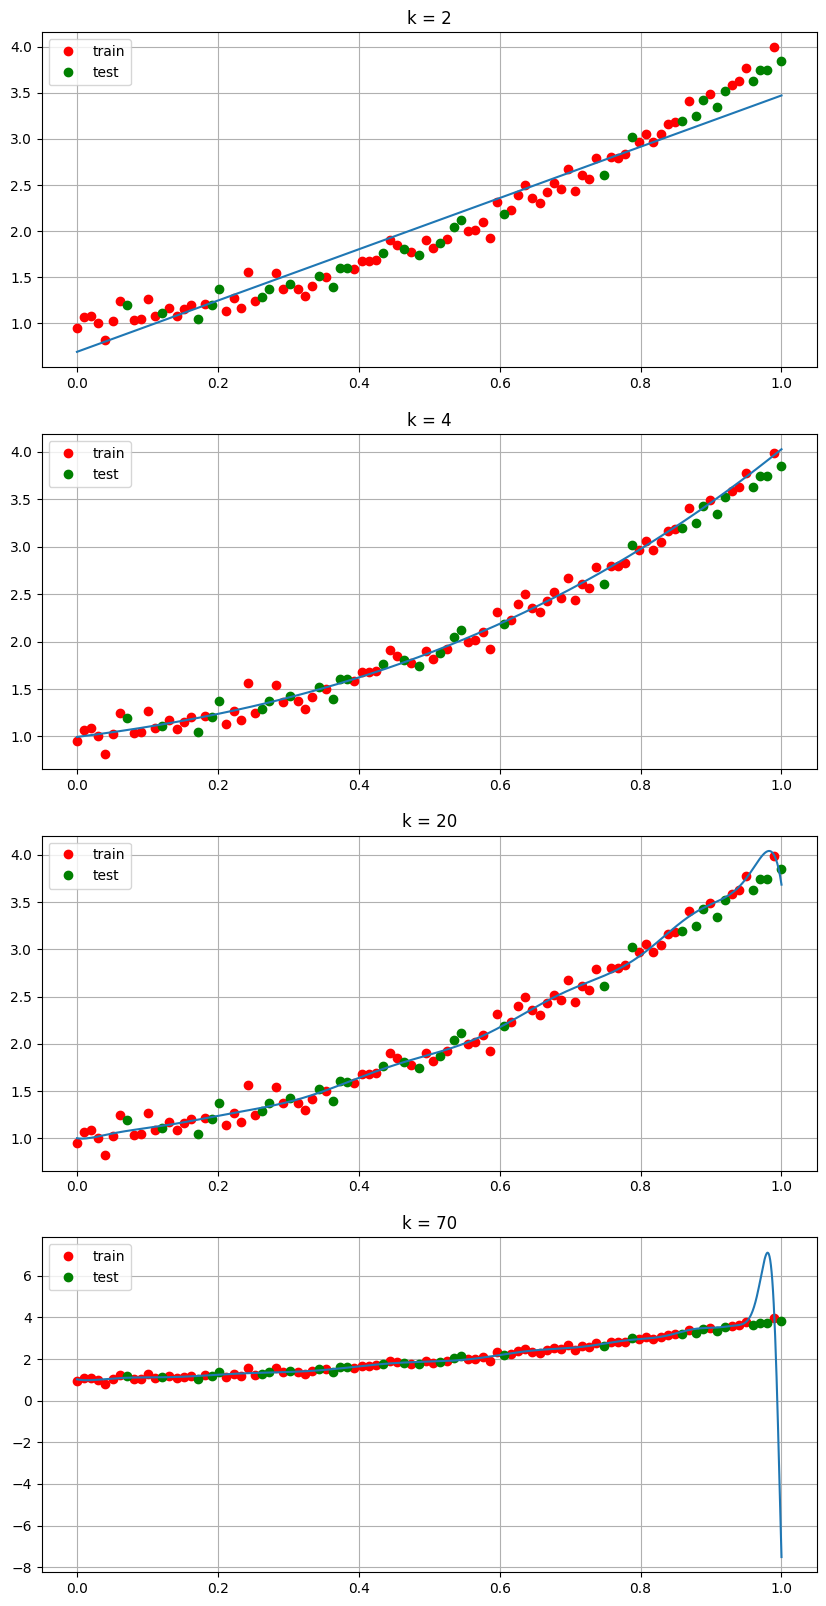

In [482]:
D_train, D_test = split_data(D[0], D[1], 70)
X_train, Y_train = D_train
X_test, Y_test = D_test

k_vector = [2, 4, 20, 70]
theta_mle_vector = []

for k in k_vector:
    theta_mle = MLE(D_train, k, "N")
    theta_mle_vector.append(theta_mle)

fig, ax = plt.subplots(len(k_vector), figsize = (10, 20))

for i in range(len(k_vector)):

    theta = theta_mle_vector[i]
    k = k_vector[i]
    
    XX = np.linspace(a, b, 1000)    #another input vector with more point so a more resoluted space (we want the result plot to be smoothed)
    YY = polynomial_regression(XX, k, theta)
    
    ax[i].set_title(f'k = {k}')
    ax[i].plot(X_train, Y_train, 'ro')
    ax[i].plot(X_test, Y_test, 'go')
    ax[i].legend(['train', 'test'])
    ax[i].plot(XX, YY)
    ax[i].grid()

plt.show()

For increasing values of K, use the functions dened above to compute the training and test error,
where the test set is generated by sampling Ntest new points on the same interval [a; b] of the
training set and generating the corresponding Ytest with the same procedure of the training set.
Plot the two errors with respect to K. Comment the results.

[]

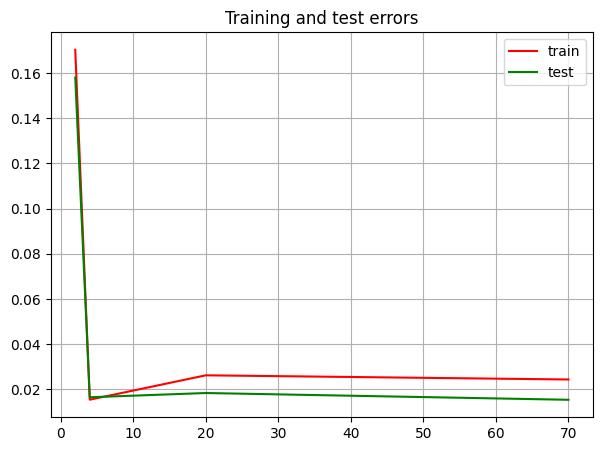

In [483]:
D_train, D_test = split_data(D[0], D[1], 70)

X_test, Y_test = D_test

k_vector = [2, 4, 20, 70]

theta_vector = []
errors_train = []
errors_test = []

for k in k_vector:
    theta_mle = MLE(D_train, k, "SGD")
    theta_vector.append(theta_mle)

    training_error = error(D_train, k, theta_mle)
    errors_train.append(training_error)
    
    test_error = error(D_test, k, theta_mle)
    errors_test.append(test_error)


plt.figure(figsize=(7,5))
plt.title("Training and test errors")
plt.plot(k_vector, errors_train, color='red')
plt.plot(k_vector, errors_test, color='green')
plt.legend(['train', 'test'])
plt.grid()
plt.plot()  

# MAP

Write a function that takes as input the training data D = (X; Y ), K and  > 0 and returns
the MAP solution (with Gaussian assumption) MAP 2 RK for that problem. Note that the loss
function can be optimized by GD, SGD or Normal Equations.

In [484]:
def MAP(D, k_trial, lmbda, mod):
    X, Y = D

    #Compute he vandermonde for the problem
    Phi = vander(X, k_trial)

    if mod[0] == 'N':        
        #Normal equation
        A = (Phi.T @ Phi) + (lmbda * np.identity(k_trial))
        b = Phi.T @ Y

        try:
            L = scipy.linalg.cholesky(A, lower = True)
            y = scipy.linalg.solve_triangular(L, b, lower = True)
            theta_MAP = scipy.linalg.solve_triangular(L.T, y)
        except:
            theta_MAP = np.linalg.solve((Phi.T @ Phi) + (lmbda * np.identity(k_trial)), Phi.T@Y)

    elif mod[0] == 'G':
        #Gradient Descent
        theta_MAP = GD(f_MAP(X, Y, lmbda), grad_f_MAP(X, Y, lmbda), np.zeros((k_trial, )))
    
    else:
        #Stochastic Gradient Descent
        theta_MAP = SGD(grad_f_MAP, np.zeros((k_trial, )), D, 5, 10, lmbda)

    return theta_MAP

theta_map_normal = MAP(D, k_chosen, 1, 'Normal equation')
theta_map_gd = MAP(D, k_chosen, 1, 'GD')
theta_map_sgd = MAP(D, k_chosen, 1, 'SGD')

print("Theta, MAP, lambda = 1 - Normal equation: ", theta_map_normal)
print("Theta, MAP, lambda = 1 - GD: ", theta_map_gd)
print("Theta, MAP, lambda = 1 - SGD: ", theta_map_sgd)


Theta, MAP, lambda = 1 - Normal equation:  [0.99130276 1.08422843 0.97917905 0.84424446]
Theta, MAP, lambda = 1 - GD:  [1.00246331 1.0721319  0.94740154 0.82506961]
Theta, MAP, lambda = 1 - SGD:  [0.9957017  0.7366632  0.58747107 0.4894242 ]


For K lower, equal and greater than the correct degree of the test polynomial, plot the training
datapoints and the test datapoints with dierent colors, and visualize (as a continuous line) the
learnt regression model fMAP (x) with dierent values of . Comment the results.


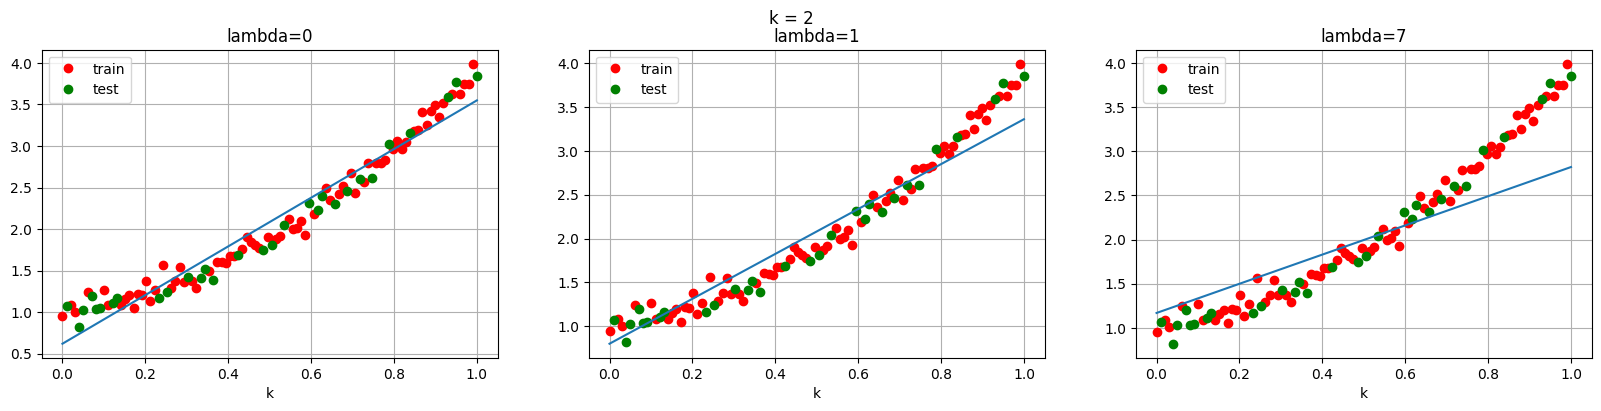

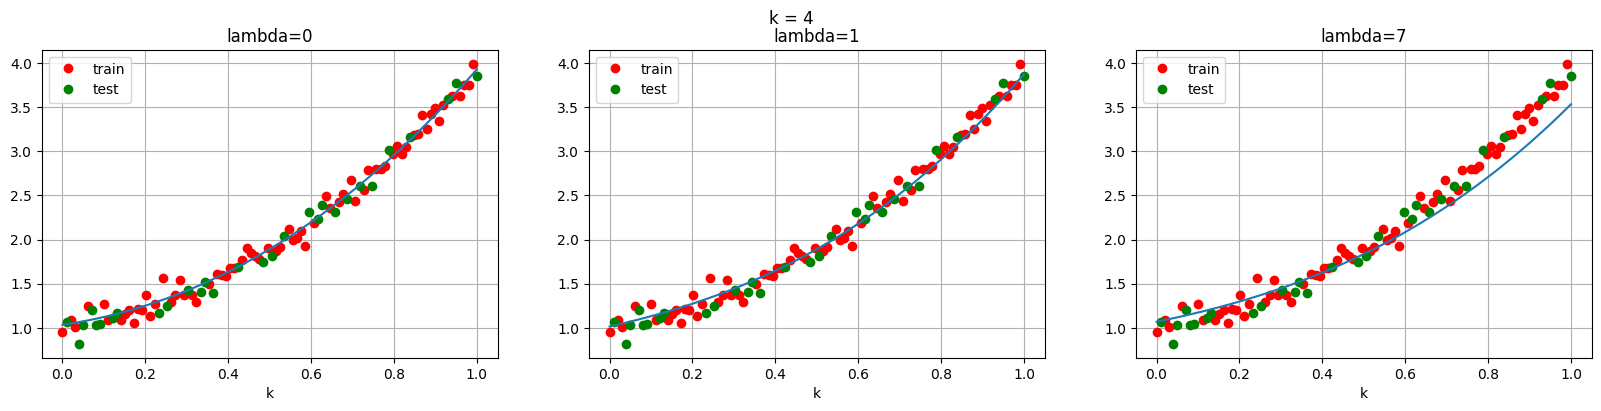

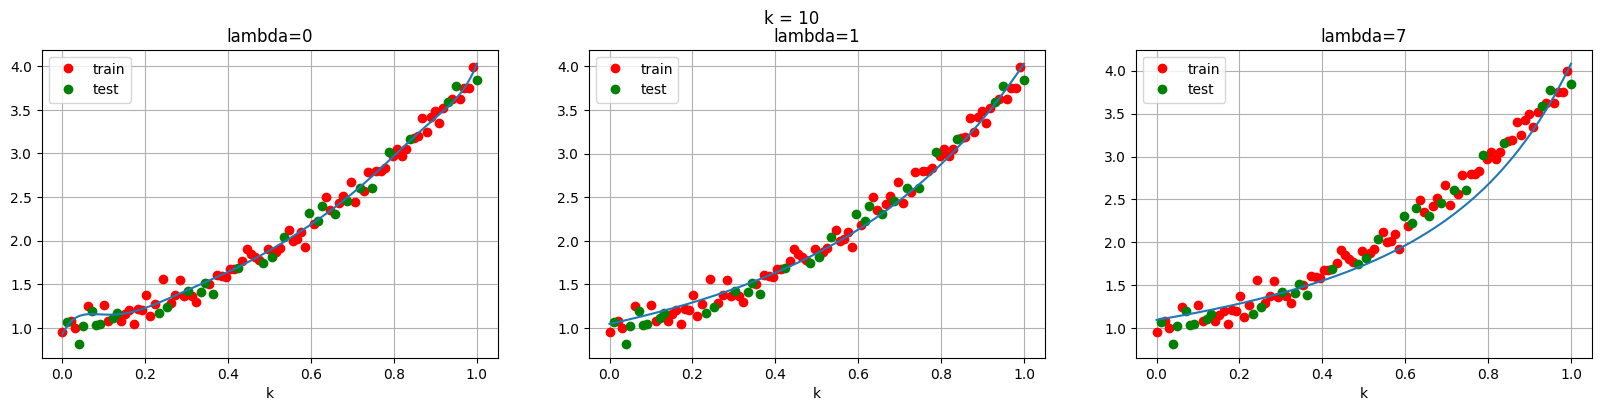

In [485]:
D_train, D_test = split_data(D[0], D[1], 70)
X_train, Y_train = D_train
X_test, Y_test = D_test

k_vector = [2, 4, 10]
l_vector = [0, 1, 7]

theta_tot_k = []

for k in k_vector:
    
    theta_tot_l = []

    for l in l_vector:
        theta_map = MAP(D_train, k, l, "Normal equation")

        theta_tot_l.append(theta_map)

    theta_tot_k.append(theta_tot_l)

for i in range(len(k_vector)):
    k = k_vector[i]

    plt.figure(figsize=(20, 4))
    plt.suptitle(f'k = {k}')

    for j in range(len(theta_tot_k[i])):
        theta = theta_tot_k[i][j]
            
        plt.subplot(1, len(theta_tot_k[i]), j+1)
        plt.title(f"lambda={l_vector[j]}")

        #for theta in range(len(theta_tot_k[i][j])):
        plt.xlabel('k')
        
        XX = np.linspace(a, b, 1000)    #another input vector with more point so a more resoluted space (we want the result plot to be smoothed)
        YY = polynomial_regression(XX, k, theta)
        plt.plot(X_train, Y_train, 'ro')
        plt.plot(X_test, Y_test, 'go')
        plt.legend(['train', 'test'])
        plt.plot(XX, YY)
        plt.grid()

plt.show()

# MLE and MAP

For K being way greater than the correct degree of the polynomial, compute the MLE and MAP
solution. Compare the test error of the two, for dierent values of  (in the case of MAP).

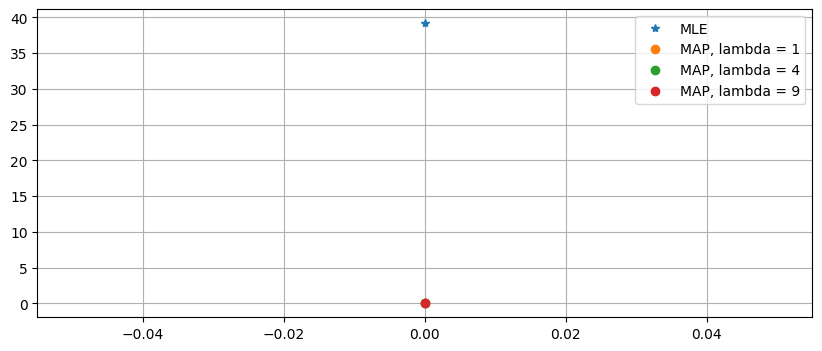

In [486]:
k_big = 70
l_vector = [1, 4, 9]
D_train, D_test = split_data(D[0], D[1], 70)

theta_mle = MLE(D_train, k_big, "Normal equation")

thetas_map = [MAP(D_train, k_big, l, "Normal equation") for l in l_vector]

mle_error = error(D_test, k_big, theta_mle)

map_errors = [error(D_test, k_big, theta_map) for theta_map in thetas_map]

legend_mle = ['MLE']
legend_map = ['MAP, lambda = ' + str(l) + '' for l in l_vector]
legend = legend_mle + legend_map

plt.figure(figsize=(10,4))
plt.plot(mle_error, '*')
for i in range(len(l_vector)):
    plt.plot(map_errors[i], 'o')
plt.legend(legend)
plt.grid()
plt.show()

For K greater than the true degree of the polynomial, dene Err() = jj􀀀truejj2
jjtruejj2
where true
has been padded with zeros to match the shape of . Compute Err(MLE) and Err(MAP ) for
increasing values of K and dierent values of 

In [487]:
def err_theta(theta, k):
    theta_true = np.ones((k,))
    diff = len(theta) - k
    if(diff > 0):
        theta_true = np.concatenate(theta_true, np.zeros(diff,))
    return np.linalg.norm(theta - theta_true) / np.linalg.norm(theta_true)

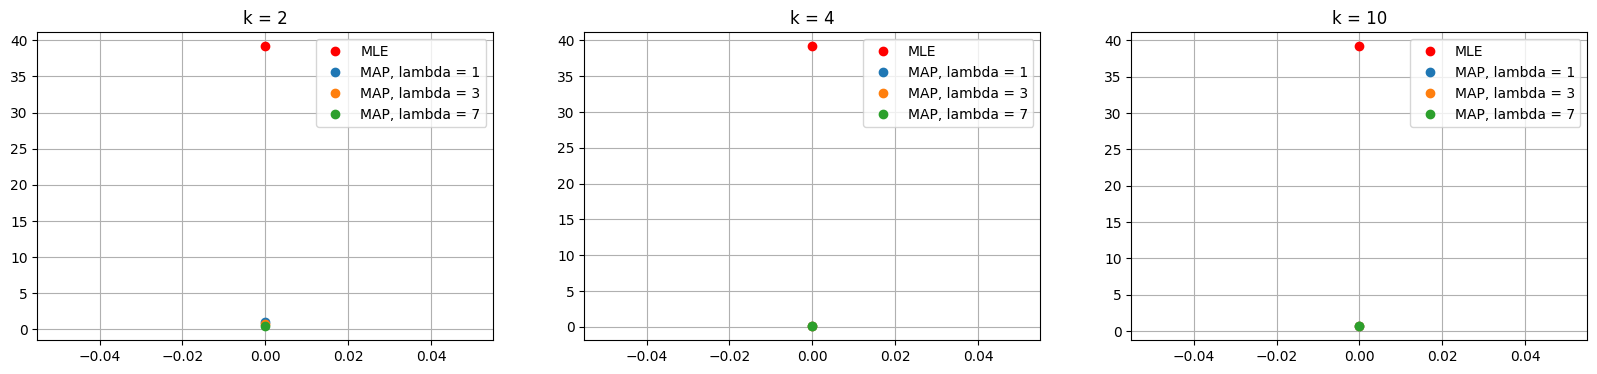

In [489]:
k_vector = [2, 4, 10]
l_vector = [1, 3, 7]

theta_mle_error_tot_k = []
theta_map_error_tot_k = []

for k in k_vector:
    
    theta_mle = MLE(D_train, k, "Normal equation")
    error_mle = err_theta(theta_mle, k)
    theta_mle_error_tot_k.append(error_mle)

    theta_map_tot_l = []

    for l in l_vector:
        theta_map = MAP(D_train, k, l, "Normal equation")
        error_map = err_theta(theta_map, k)
        theta_map_tot_l.append(error_map)

    theta_map_error_tot_k.append(theta_map_tot_l)

legend_mle = ['MLE']
legend_map = ['MAP, lambda = ' + str(l) + '' for l in l_vector]
legend = legend_mle + legend_map

plt.figure(figsize=(20, 4))

for i in range(len(k_vector)):
    k = k_vector[i]
    
    plt.subplot(1, len(theta_map_error_tot_k[i]), i+1)
    plt.title(f'k = {k}')
    plt.plot(mle_error, 'ro')

    for j in range(len(theta_map_error_tot_k[i])):    
        map_error_ = theta_map_error_tot_k[i][j]
        plt.plot(map_error_, 'o')
    
    plt.legend(legend)
    plt.grid()

plt.show()